### DATA Downloading and Preparation

In [1]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
data = new_client.target
data_query = data.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(data_query)
###@@data_features = pd.DataFrame(targets.data , columns=targets.feature_names)
data_new = new_client.activity
data1 = data_new.filter(target_chembl_id='CHEMBL220').filter(standard_type="IC50")
df = pd.DataFrame.from_dict(data1)
#dropping records which donot have values in columns standard_value and canonical_smiles
df2 = df[df.standard_value.notna()]
df2 = df2[df2.canonical_smiles.notna()]
#dropping records with duplicate canonical_smiles values to keep them unique
df2_unique = df2.drop_duplicates(['canonical_smiles'])
df2.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8


In [2]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_unique[selection]
bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active


In [3]:
def pIC50(input):
    pIC50 = []
    count = 0
    for i in input['standard_value_norm']:
        try:
            molar = i*(10**-9) # Converts nM to M
            if(molar==0):
                molar = 10**-10
                count = count + 1
            pIC50.append(-np.log10(molar))
        except:
            pIC50.append("error")
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)        
    return x

def norm_value(input):
    norm = []
    for i in input['standard_value']:
        if float(i) > 100000000:
          i = 100000000
        norm.append(float(i))
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)       
    return x



### Active and inactive compound comparison

/tmp/ipykernel_963507/1786897481.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)
/tmp/ipykernel_963507/1786897481.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,canonical_smiles,molecule_chembl_id
0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,CHEMBL133897
1,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,CHEMBL336398
2,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,CHEMBL131588
3,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,CHEMBL130628
4,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,CHEMBL130478


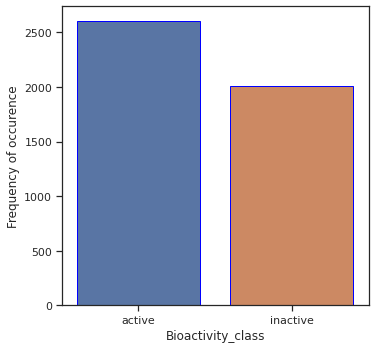

In [4]:
df_norm = norm_value(df4)
df_norm.standard_value_norm.describe()
df_final = pIC50(df_norm)
df_final.pIC50.describe()
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='blue')
plt.xlabel('Bioactivity_class', fontsize=12)
plt.ylabel('Frequency of occurence', fontsize=12)
plt.savefig('plot_bioactivity_class.pdf')
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df_final[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)
df3_selection.head()

### XGBOOST Model Training

[18:27:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


/home/avisouser/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


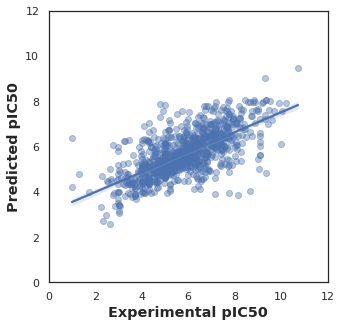

In [5]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
df = pd.read_csv('padel/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
X = df.drop('pIC50', axis=1)
Y = df.pIC50
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
xgb_r.fit(X_train, Y_train)
Y_pred = xgb_r.predict(X_test)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("white")
ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show
plt.savefig('prediction_plot.pdf')

### here we try to plot model again with different squared error

/home/avisouser/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/avisouser/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


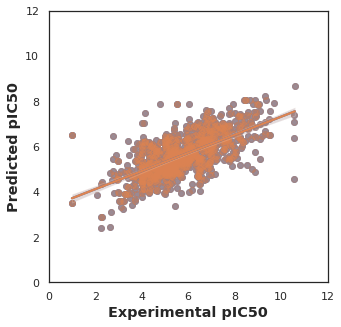

In [7]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
df = pd.read_csv('padel/acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
X = df.drop('pIC50', axis=1)
Y = df.pIC50
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123)
xgb_r.fit(X_train, Y_train)
Y_pred = xgb_r.predict(X_test)
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.regplot(Y_test, Y_pred)
ax.set_xlabel('Experimental_pIC50')
ax.set_ylabel('Predicted_pIC50')
plt.savefig('prediction_plot2.pdf')
#sns.set(color_codes=True)
#sns.set_style("white")
ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show
plt.savefig('prediction_plot1.pdf')

### Drawing data analysis graphs

/tmp/ipykernel_963507/603988736.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


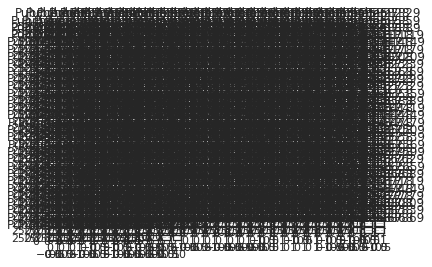

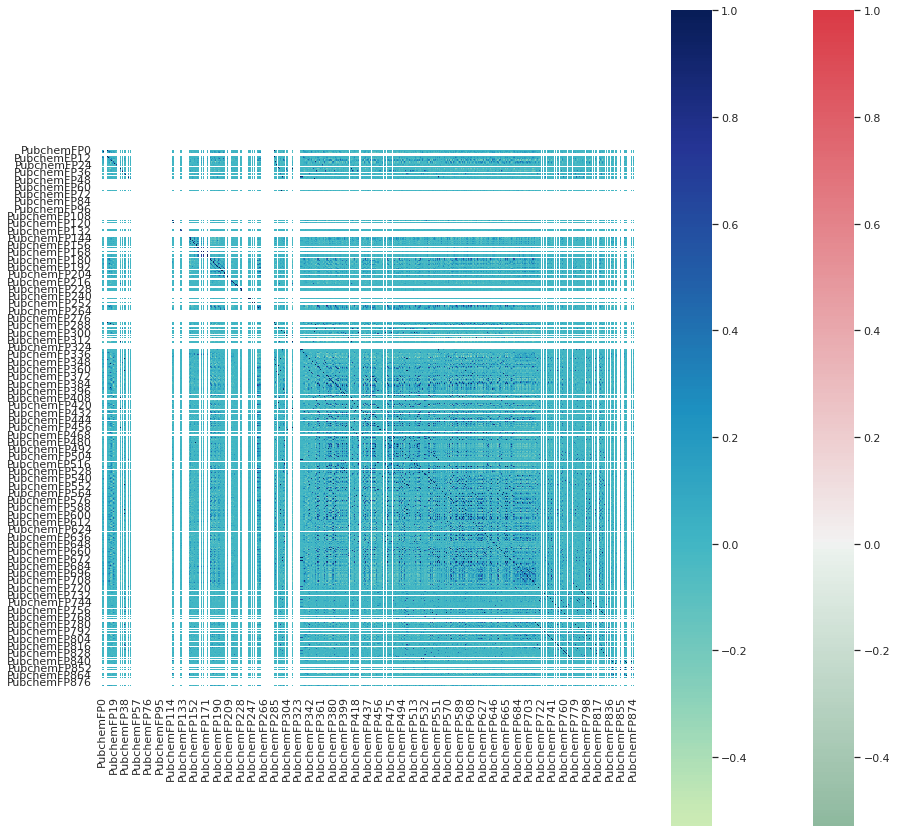

In [8]:
import matplotlib.pyplot as plt
df.hist()
plt.tight_layout()
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(15, 15)
cmap=sns.diverging_palette(500,10,as_cmap=True)
sns.heatmap(df.corr(),cmap=cmap,center=0,annot=False,square=True)
sns.heatmap(df.corr(),cmap='YlGnBu',center=0,square=True)
plt.show()

### convert data type from object to categorical to view further

In [9]:
df10 = df
error = 0
count = 0

for col in df.columns:
	if(df[col].dtype == 'object'):
		try:
			df[col] = df[col].astype('category')
			df[col] = df[col].cat.codes
			count = count + 1
		except :
			error = error + 1
